In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Fix OMP: Error #15: Initializing libiomp5.dylib on MacOS
# https://github.com/dmlc/xgboost/issues/1715
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# Read training data from directory
image_size = (128, 128)
batch_size = 128
num_classes = 100

# Generate batches of tensor image data
train_ds = ImageDataGenerator().flow_from_directory(
    '../data/images/train/',
    target_size=image_size,
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    seed=12345,
    interpolation="bilinear")

# Check a batch for sanity
batchX, batchy = train_ds.next()
print('Input batch X shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))
print('Output batch y shape=%s, min=%.3f, max=%.3f' % (batchy.shape, batchy.min(), batchy.max()))
print('Label Mappings:')
print(train_ds.class_indices)
indices_class = {v: k for k, v in train_ds.class_indices.items()}

Found 100000 images belonging to 100 classes.
Input batch X shape=(128, 128, 128, 3), min=0.000, max=255.000
Output batch y shape=(128, 100), min=0.000, max=1.000
Label Mappings:
{'abbey': 0, 'airport_terminal': 1, 'amphitheater': 2, 'amusement_park': 3, 'aquarium': 4, 'aqueduct': 5, 'art_gallery': 6, 'assembly_line': 7, 'auditorium': 8, 'badlands': 9, 'bakery': 10, 'ballroom': 11, 'bamboo_forest': 12, 'banquet_hall': 13, 'bar': 14, 'baseball_field': 15, 'bathroom': 16, 'beauty_salon': 17, 'bedroom': 18, 'boat_deck': 19, 'bookstore': 20, 'botanical_garden': 21, 'bowling_alley': 22, 'boxing_ring': 23, 'bridge': 24, 'bus_interior': 25, 'butchers_shop': 26, 'campsite': 27, 'candy_store': 28, 'canyon': 29, 'cemetery': 30, 'chalet': 31, 'church': 32, 'classroom': 33, 'clothing_store': 34, 'coast': 35, 'cockpit': 36, 'coffee_shop': 37, 'conference_room': 38, 'construction_site': 39, 'corn_field': 40, 'corridor': 41, 'courtyard': 42, 'dam': 43, 'desert': 44, 'dining_room': 45, 'driveway': 46,

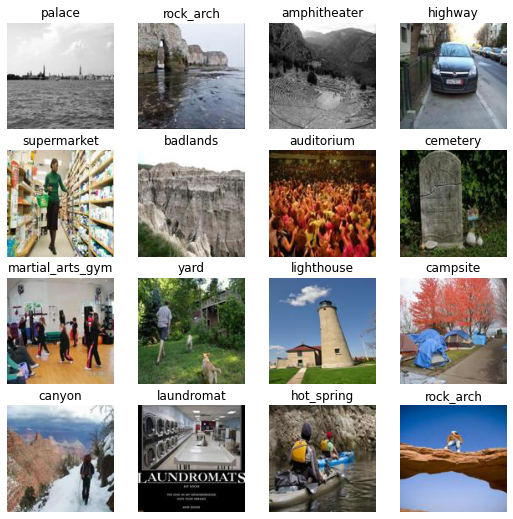

In [3]:
# Plot images from first batch for visual check
plt.figure(figsize=(9, 9))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(batchX[i].astype("uint8"))
    plt.title(indices_class[int(np.argmax(batchy[i]))])
    plt.axis("off")

In [4]:
# Start with Xception model trained on imagenet
base_model = Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)

# Add a custom top classifier on top of Xception base model for our dataset with 100 classes
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.inputs, outputs=predictions)

# Freeze the base model layers, only train the top classifier
for layer in base_model.layers:
    layer.trainable = False
        
# Compile the model, use a coarser learning rate with Adam optimizer for the top layer training
model.compile(
    optimizer=Adam(lr=1e-3), 
    loss='categorical_crossentropy',
    metrics=['accuracy', 'top_k_categorical_accuracy'])


In [5]:
# Train top classifier
epochs = 5

# Create checkpoints to save model weights at each epoch
callbacks = [ModelCheckpoint("coarse_train_{epoch}.h5")]

# Train the model
coarse_train = model.fit(
    train_ds,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks
)

Train for 782 steps
Epoch 1/5
782/782 [==============================] - 3568s 5s/step - loss: 3.0754 - accuracy: 0.2770 - top_k_categorical_accuracy: 0.5568
Epoch 2/5
782/782 [==============================] - 3546s 5s/step - loss: 2.4472 - accuracy: 0.3813 - top_k_categorical_accuracy: 0.6847
Epoch 3/5
782/782 [==============================] - 3545s 5s/step - loss: 2.0937 - accuracy: 0.4538 - top_k_categorical_accuracy: 0.7527
Epoch 4/5
782/782 [==============================] - 3476s 4s/step - loss: 1.7232 - accuracy: 0.5411 - top_k_categorical_accuracy: 0.8193
Epoch 5/5
782/782 [==============================] - 3470s 4s/step - loss: 1.3449 - accuracy: 0.6413 - top_k_categorical_accuracy: 0.8802


In [6]:
# At this point, the top layers are decently trained and we can start fine-tuning
# convolutional layers from Xception with a smaller learning rate

# Make all layers trainable
for layer in base_model.layers:
    layer.trainable = True
        
# Compile the model, use a finer learning rate with Adam optimizer for tuning all layers
model.compile(
    optimizer=Adam(lr=1e-4), 
    loss='categorical_crossentropy',
    metrics=['accuracy', 'top_k_categorical_accuracy'])

In [7]:
# Train full model
epochs = 5

# Create checkpoints to save model weights at each epoch
callbacks = [ModelCheckpoint("fine_train_{epoch}.h5")]

# Train the model
fine_train = model.fit(
    train_ds,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks
)

Train for 782 steps
Epoch 1/5
782/782 [==============================] - 8097s 10s/step - loss: 0.9590 - accuracy: 0.7342 - top_k_categorical_accuracy: 0.9281
Epoch 2/5
782/782 [==============================] - 8326s 11s/step - loss: 0.2241 - accuracy: 0.9490 - top_k_categorical_accuracy: 0.9928
Epoch 3/5
782/782 [==============================] - 8491s 11s/step - loss: 0.0458 - accuracy: 0.9947 - top_k_categorical_accuracy: 0.9995
Epoch 4/5
782/782 [==============================] - 8212s 11s/step - loss: 0.0112 - accuracy: 0.9995 - top_k_categorical_accuracy: 0.9998
Epoch 5/5
782/782 [==============================] - 8365s 11s/step - loss: 0.0056 - accuracy: 0.9996 - top_k_categorical_accuracy: 0.9998
